## Melanoma Detection using a Custom CNN in Keras+TensorFlow

### Problem statement

#### Melanoma, a deadly skin cancer, is curable if detected early. This project aims to develop a CNN-based model to accurately detect melanoma from dermatological images, potentially assisting dermatologists and reducing manual diagnosis efforts.

The dataset comprises 2357 images of various malignant and benign skin conditions from the International Skin Imaging Collaboration (ISIC). It includes a diverse set of diseases, with a slight dominance of melanoma and mole images.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

#### Paths are defined for the training and test images. The dataset is sorted according to ISIC classifications, with nine classes represented.


In [2]:
import os
import pathlib

# This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Assuming this script is in same folder as extracted 'CNN_assignment' folder
# Defining the path for train and test images
data_dir_train = pathlib.Path("CNN_assignment", "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
#print(data_dir_train.resolve())

data_dir_test = pathlib.Path("CNN_assignment", "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")
#print(data_dir_test.resolve())


### Data Understanding

In [3]:
%%time

# Display images count in both Train and Test folders.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118
CPU times: total: 31.2 ms
Wall time: 24.7 ms


In [4]:
from pathlib import Path
import numpy as np

# data_dir_train is the training dataset path
data_dir_train = Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Count the number of files in each class directory
class_counts = {class_dir.name: len(list(class_dir.glob('*'))) for class_dir in data_dir_train.iterdir() if class_dir.is_dir()}

# Print the number of samples per class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Find the class with the least number of samples
least_samples_class = min(class_counts, key=class_counts.get)
print(f"\nClass with the least number of samples: {least_samples_class} ({class_counts[least_samples_class]})")

# Find the classes that dominate the dataset
most_samples_class = max(class_counts, key=class_counts.get)
print(f"Class with the most number of samples: {most_samples_class} ({class_counts[most_samples_class]})")

# Calculate the proportion of samples per class
total_samples = sum(class_counts.values())
class_proportions = {class_name: count / total_samples for class_name, count in class_counts.items()}

# Sort the class proportions dictionary by proportion of samples, in descending order
sorted_class_proportions = sorted(class_proportions.items(), key=lambda item: item[1], reverse=True)

# Print the sorted proportions
for class_name, proportion in sorted_class_proportions:
    print(f"{class_name}: {proportion:.2%}")


actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139

Class with the least number of samples: seborrheic keratosis (77)
Class with the most number of samples: pigmented benign keratosis (462)
pigmented benign keratosis: 20.63%
melanoma: 19.56%
basal cell carcinoma: 16.79%
nevus: 15.94%
squamous cell carcinoma: 8.08%
vascular lesion: 6.21%
actinic keratosis: 5.09%
dermatofibroma: 4.24%
seborrheic keratosis: 3.44%


#### Class with the least number of samples: seborrheic keratosis (77)
#### Class with the most number of samples: pigmented benign keratosis (462)

#### Dominating classes:
- Pigmented benign keratosis: 20.63%
- Melanoma: 19.56%
- Basal cell carcinoma: 16.79%
- Nevus: 15.94%


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Create the training dataset with a validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",
    seed=123,  # Ensure reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Create the validation dataset from the same directory with the same split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Match the validation split used for training
    subset="validation",
    seed=123,  # Use the same seed to ensure the data doesn't overlap with train_ds
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

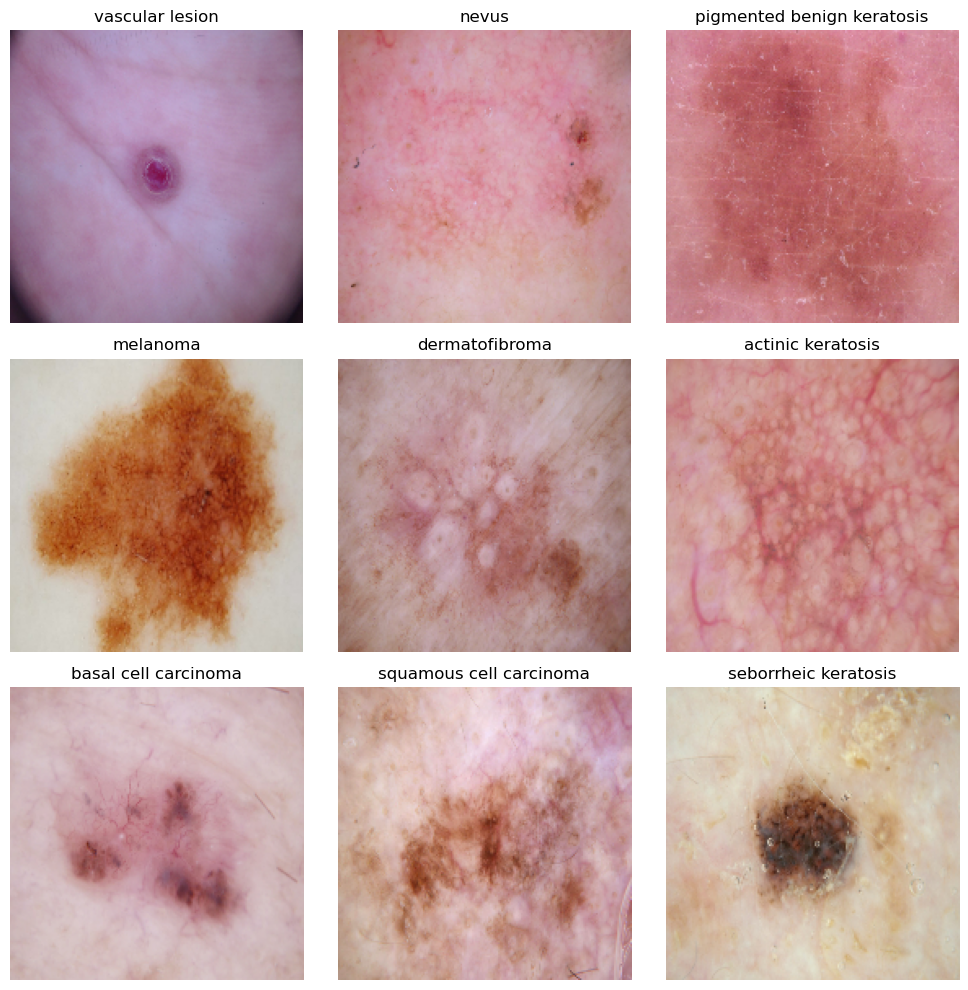

In [9]:
import matplotlib.pyplot as plt

# This dictionary will hold one image for each class
class_images = {}

# Iterate over the dataset to collect the first instance of each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label]
        if class_name not in class_images:
            class_images[class_name] = image.numpy().astype('uint8')
        if len(class_images) == 9:  # Stop if we have collected one of each class
            break
    if len(class_images) == 9:
        break

# Plot the images
plt.figure(figsize=(10, 10))
for i, (class_name, image) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & Training (Initial)
A custom CNN model is created to detect the nine classes, with image rescaling as a part of the model.
An appropriate optimizer and loss function are chosen.
The model is trained for ~20 epochs, and the fit is assessed for evidence of overfitting or underfitting.`

In [11]:
%%time

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Convolutional base
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening the output of the conv base to feed into the dense layers
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Use softmax for multi-class classification
])




CPU times: total: 719 ms
Wall time: 502 ms


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
%%time

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 47s 666ms/step - loss: 2.0463 - accuracy: 0.2355 - val_loss: 1.8763 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 37s 668ms/step - loss: 1.8072 - accuracy: 0.3499 - val_loss: 1.8985 - val_accuracy: 0.2752
Epoch 3/20
56/56 [==============================] - 34s 600ms/step - loss: 1.6276 - accuracy: 0.4213 - val_loss: 1.5225 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 34s 611ms/step - loss: 1.4395 - accuracy: 0.4950 - val_loss: 1.5091 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 34s 608ms/step - loss: 1.3650 - accuracy: 0.5195 - val_loss: 1.4330 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 34s 602ms/step - loss: 1.3267 - accuracy: 0.5268 - val_loss: 1.4653 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 34s 604ms/step - loss: 1.2319 - accuracy: 0.5603 - val_loss: 1.4045 - val_accuracy: 0.53

### Visualizing training results

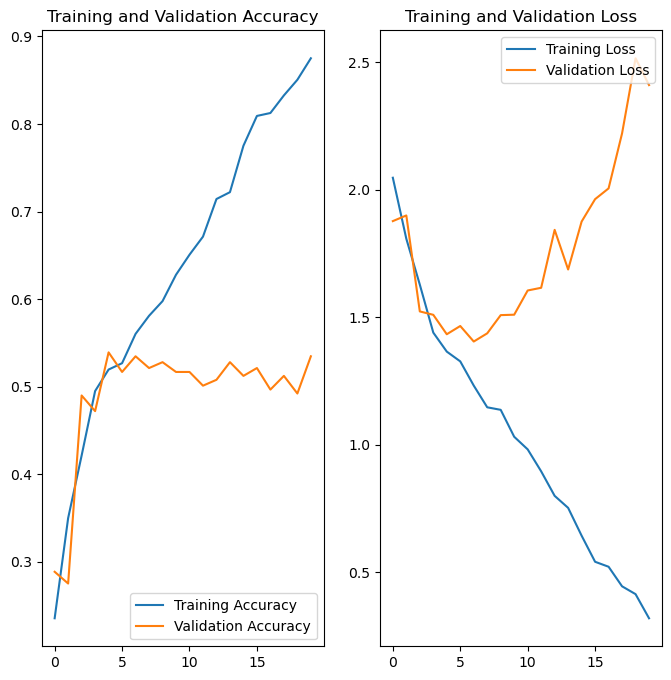

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<a id="basic_model"></a>#### Initial Model Asssesmet

#### As we observe this model is severly Overfitting as the Validation accuracy is too low. (val_accuracy: 0.1304).

Epoch 20/20
112/112 [==============================] - 34s 302ms/step - loss: 0.4420 - accuracy: 0.8326 - val_loss: 8.0570 - val_accuracy: 0.1304

## Data Augmentation

### A data augmentation strategy is implemented to address any fitting issues.


Found 2239 files belonging to 9 classes.


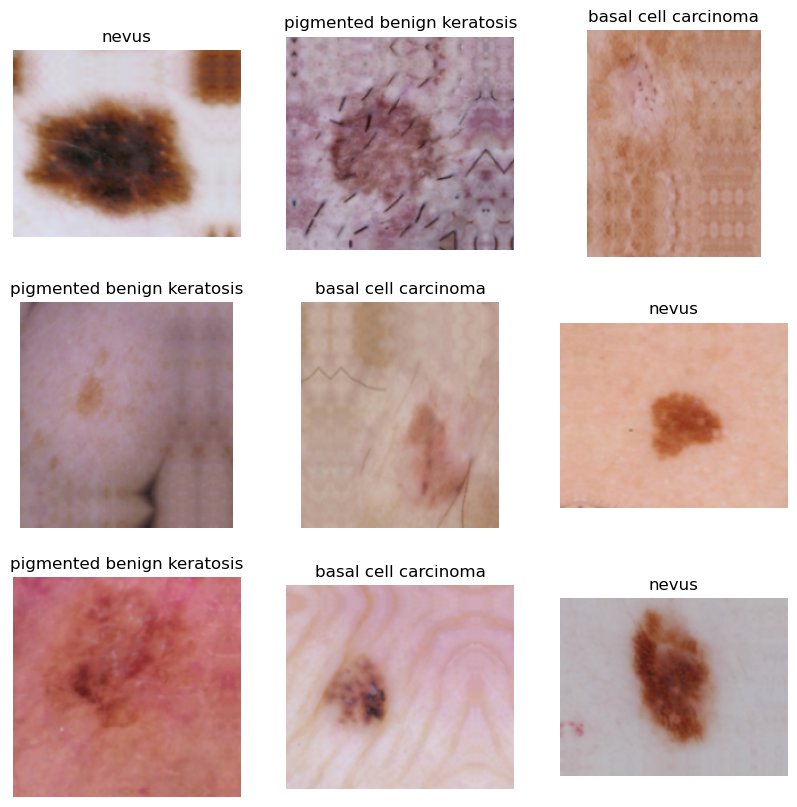

CPU times: total: 19.5 s
Wall time: 7.46 s


In [16]:
%%time 

import tensorflow as tf
import matplotlib.pyplot as plt

# Load the datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=32
)

# Store class names before applying the map transformation
class_names = train_ds.class_names

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])

# Shuffle the dataset and take one batch
shuffled_train_ds = train_ds.shuffle(1000)  # Shuffle with a buffer size of 1000
shuffled_batch = shuffled_train_ds.take(1)

# Visualize the augmented images
plt.figure(figsize=(10, 10))
for images, labels in shuffled_batch:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Apply augmentation to the i-th image in the shuffled batch
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()
    break  # We only need the first shuffled batch, so break after processing it


### Data Augmentation with Augmentor

Augmentor package is used to add more image samples, say 500 to each class. It also does some image transformation such as rotation.


In [17]:
!pip install Augmentor

In [18]:
%%time

import Augmentor

# Loop over the class names and create an Augmentor pipeline for each class
for i in class_names:
    # Create an Augmentor Pipeline for the current class directory
    p = Augmentor.Pipeline(str(data_dir_train / i))  # Use the '/' operator to join paths with pathlib
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AAC4BC9FD


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AAC4661D1


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AAC4632F5


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x1AAC4BE2


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1AAC463C


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AAC499AC1


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AAC4C7D0


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x4


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AAC47BB05

CPU times: total: 7min 29s
Wall time: 2min 11s


In [19]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [20]:
from pathlib import Path
import shutil

# data_dir_train is a Path object pointing to the training directory
output_dirs = list(data_dir_train.glob('*/output'))

for output_dir in output_dirs:
    for img_path in output_dir.glob('*.jpg'):
        # Define a new path for the image in the class directory
        new_path = img_path.parents[1] / img_path.name
        # Move the image
        shutil.move(str(img_path), str(new_path))
    # Optionally, remove the now-empty output directory
    output_dir.rmdir()


In [21]:
# Adjust the glob pattern to count all .jpg images directly within class directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))

print(f"Total images after augmentation and reorganization: {image_count_train}")

Total images after augmentation and reorganization: 6739


### Lets see the distribution of augmented data after adding new images to the original training data.

Found 6739 files belonging to 9 classes.


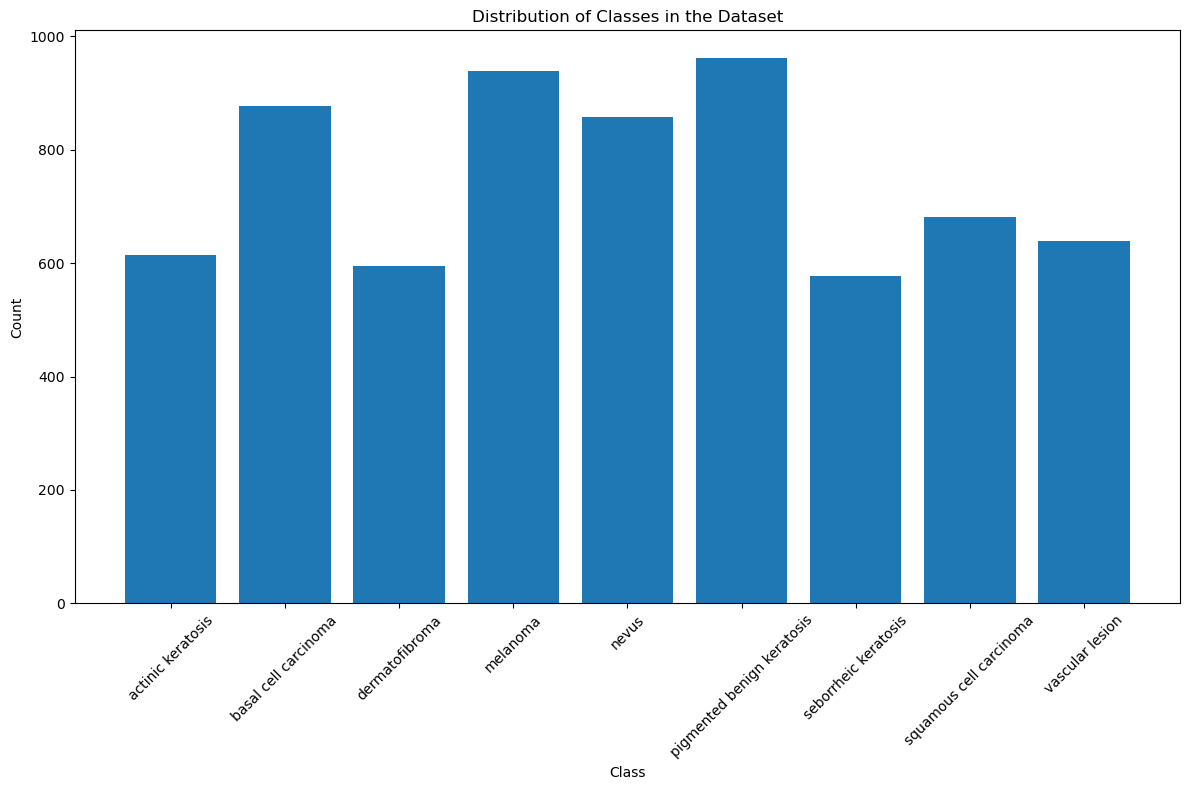

In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf

train_ds_original = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(180, 180),
    batch_size=32
)

class_names = train_ds_original.class_names  # Extract class names here

# Apply prefetching to a temporary variable instead of modifying train_ds_original
train_ds_temp = train_ds_original.prefetch(tf.data.experimental.AUTOTUNE)

# Initialize a dictionary to hold the count of each class
class_counts = {class_name: 0 for class_name in train_ds_original.class_names}

# Iterate over the original dataset to count each class
for images, label in train_ds_original.unbatch().as_numpy_iterator():
    class_name = train_ds_original.class_names[label]
    class_counts[class_name] += 1

# Plot the distribution
plt.figure(figsize=(12, 8))
plt.bar(class_counts.keys(), class_counts.values(), align='center')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Dataset')
plt.tight_layout()
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model Building & Training (Post-Augmentation)

#### The model creation process is repeated with data augmentation in place. 
#### Now we include techniques such as BatchNormalization and Dropouts for preventing Overfitting.
#### The model is trained for ~20 initially and then additional epochs as needed.
#### EarlyStopping and ModelCheckpoint are also defined to optimize training resources.
#### The effectiveness of the augmentation strategy is evaluated.


#### ** Training Iteration1:

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers

# Setting a seed for reproducibility
tf.random.set_seed(42)

# Model constants
img_height, img_width = 180, 180  # Image dimensions
num_classes = 9  # Number of output classes

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal_and_vertical'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.1),
  preprocessing.RandomContrast(0.1),
])

# Building the model
model = models.Sequential([
    # Input layer that specifies the input shape of the images
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    # Data augmentation
    data_augmentation,
    
    # Rescaling layer to normalize pixel values
    preprocessing.Rescaling(1./255),
    
    # Convolutional blocks
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flattening the output to feed into the dense layer
    layers.Flatten(),
    
    # Dense layers with dropout and L2 regularization
    layers.Dense(512, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax'),
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)       

In [26]:
%%time

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Optimizing the data pipeline for efficiency
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Callbacks for further training
# EarlyStopping: Monitor validation loss, with patience for N epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# ModelCheckpoint: Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='model_best_checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Adjust epochs based on early stopping
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 7.0942 - accuracy: 0.5690
Epoch 1: val_loss improved from inf to 6.68505, saving model to model_best_checkpoint.h5
70/70 [==============================] - 75s 1s/step - loss: 7.0942 - accuracy: 0.5690 - val_loss: 6.6850 - val_accuracy: 0.6421 - lr: 1.0000e-04
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 6.8126 - accuracy: 0.5690
Epoch 2: val_loss improved from 6.68505 to 6.43819, saving model to model_best_checkpoint.h5
70/70 [==============================] - 75s 1s/step - loss: 6.8126 - accuracy: 0.5690 - val_loss: 6.4382 - val_accuracy: 0.6174 - lr: 1.0000e-04
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 6.5475 - accuracy: 0.5788
Epoch 3: val_loss improved from 6.43819 to 6.15149, saving model to model_best_checkpoint.h5
70/70 [==============================] - 75s 1s/step - loss: 6.5475 - accuracy: 0.5788 - val_loss: 6.1515 - val_accuracy: 0.6443 - lr: 1.0000e-04
Epoch

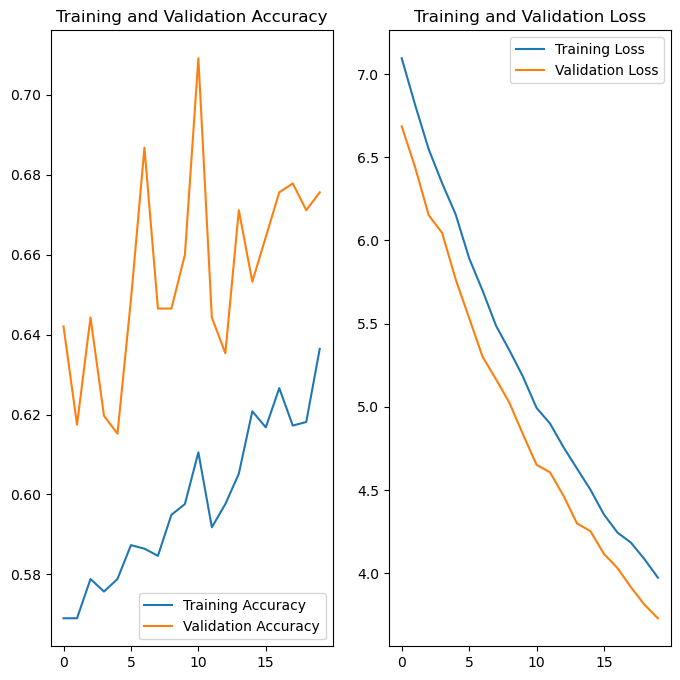

In [30]:
# Extracting the history of training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust epochs_range based on the actual number of epochs trained
epochs_range = range(len(acc))

import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Iteration1 Observation:

#### We see that we brought down the validation loss in parallel with training loss to decent extent. We can further train if we need better model with accuracy.

##### accuracy: 0.6364 - val_accuracy: 0.6756

Epoch 20/20
70/70 [==============================] - ETA: 0s - loss: 3.9728 - accuracy: 0.6364
Epoch 20: val_loss improved from 3.81045 to 3.72884, saving model to model_best_checkpoint.h5
70/70 [==============================] - 75s 1s/step - loss: 3.9728 - accuracy: 0.6364 - val_loss: 3.7288 - val_accuracy: 0.6756 - lr: 1.0000e-048

#### ** Training Iteration 2:

Here we add another 10 epochs to see if that helps with accuracy improvement.

In [34]:
%%time

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Optimizing the data pipeline for efficiency
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Callbacks for further training
# EarlyStopping: Monitor validation loss, with patience for N epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# ModelCheckpoint: Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='model_best_checkpoint_further.h5', monitor='val_loss', save_best_only=True, verbose=1)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Retrieve the last epoch number from initial training
initial_epochs = len(history.history['loss'])
additional_epochs = 10
total_epochs = initial_epochs + additional_epochs

# Continue training for additional epochs
history_continued = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Start from the last completed epoch
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 21/30
70/70 [==============================] - ETA: 0s - loss: 3.8621 - accuracy: 0.6333
Epoch 21: val_loss improved from inf to 3.72348, saving model to model_best_checkpoint_further.h5
70/70 [==============================] - 76s 1s/step - loss: 3.8621 - accuracy: 0.6333 - val_loss: 3.7235 - val_accuracy: 0.6779 - lr: 1.0000e-04
Epoch 22/30
70/70 [==============================] - ETA: 0s - loss: 3.7926 - accuracy: 0.6342
Epoch 22: val_loss improved from 3.72348 to 3.67594, saving model to model_best_checkpoint_further.h5
70/70 [==============================] - 75s 1s/step - loss: 3.7926 - accuracy: 0.6342 - val_loss: 3.6759 - val_accuracy: 0.6488 - lr: 1.0000e-04
Epoch 23/30
70/70 [==============================] - ETA: 0s - loss: 3.6934 - accuracy: 0.6431
Epoch 23: val_loss improved from 3.67594 to 3.48648, saving model to model_best_checkpoint_further.h5
70/70 [==============================] - 75s 1s/step - loss: 3.6934 - accuracy: 0.6431 - val_loss: 3.4865 - val_accuracy:

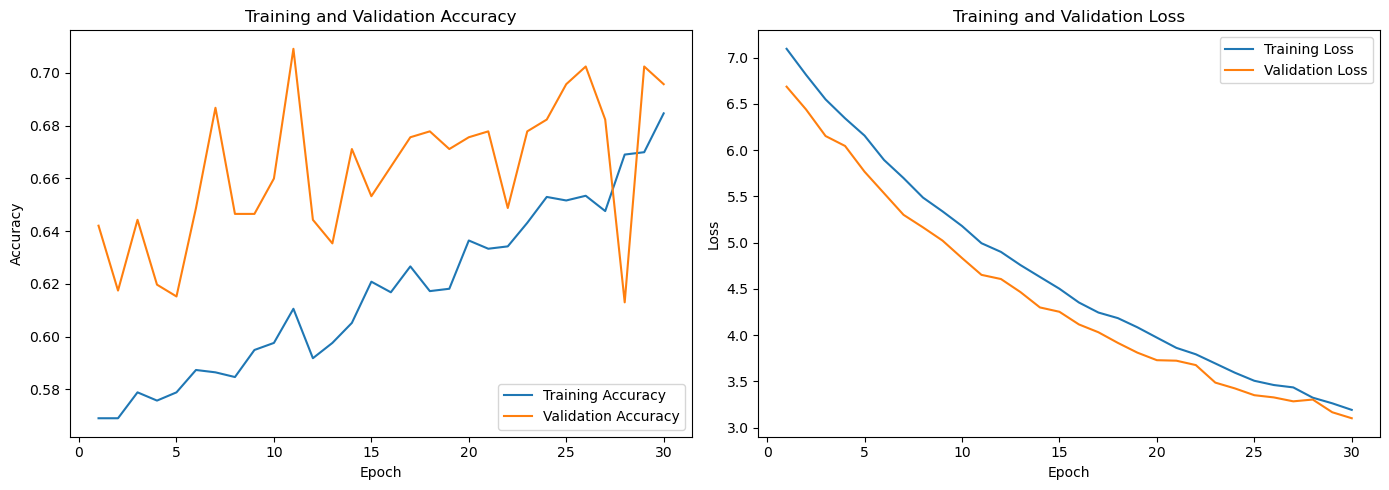

In [37]:
import matplotlib.pyplot as plt

# Concatenate the history from initial and continued training
acc = history.history['accuracy'] + history_continued.history['accuracy']
val_acc = history.history['val_accuracy'] + history_continued.history['val_accuracy']
loss = history.history['loss'] + history_continued.history['loss']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']

# Determine the total range of epochs trained
epochs_range = range(1, len(acc) + 1)  # Starting from 1 for readability

# Setup the plotting
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  
plt.show()

#### Iteration2 Observation:

##### We see that the Accuracy has improved marginally but has more scope for improvement.

##### accuracy: 0.6847 - val_accuracy: 0.6957

Epoch 30/30
70/70 [==============================] - ETA: 0s - loss: 3.1918 - accuracy: 0.6847
Epoch 30: val_loss improved from 3.16619 to 3.10135, saving model to model_best_checkpoint_further.h5
70/70 [==============================] - 76s 1s/step - loss: 3.1918 - accuracy: 0.6847 - val_loss: 3.1014 - val_accuracy: 0.6957 - lr: 1.0000e-04

### ** Training Iteration3:

##### We continue training to see if the best model can improve validation accuracy further. We add EarlyStopping and let it continue for another 50 epochs.

In [36]:
%%time 

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='model_best_checkpoint_continued.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# 'history_continued' is from the last training session and contains its history
initial_epochs = len(history_continued.history['loss'])
additional_epochs = 50
total_epochs = initial_epochs + additional_epochs

# Continue training for additional epochs
history_continued_further = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Ensure this is set correctly based on previous training
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 11/60
70/70 [==============================] - ETA: 0s - loss: 3.1849 - accuracy: 0.6677
Epoch 11: val_loss improved from inf to 3.08845, saving model to model_best_checkpoint_continued.h5
70/70 [==============================] - 77s 1s/step - loss: 3.1849 - accuracy: 0.6677 - val_loss: 3.0885 - val_accuracy: 0.6756 - lr: 1.0000e-04
Epoch 12/60
70/70 [==============================] - ETA: 0s - loss: 3.0932 - accuracy: 0.6757
Epoch 12: val_loss improved from 3.08845 to 3.04510, saving model to model_best_checkpoint_continued.h5
70/70 [==============================] - 76s 1s/step - loss: 3.0932 - accuracy: 0.6757 - val_loss: 3.0451 - val_accuracy: 0.7047 - lr: 1.0000e-04
Epoch 13/60
70/70 [==============================] - ETA: 0s - loss: 3.0517 - accuracy: 0.6909
Epoch 13: val_loss did not improve from 3.04510
70/70 [==============================] - 73s 1s/step - loss: 3.0517 - accuracy: 0.6909 - val_loss: 3.0686 - val_accuracy: 0.7025 - lr: 1.0000e-04
Epoch 14/60
70/70 [======

### Iteration3 Observation: Conclusion

#### Finally, we see that the Accuracy has improved well along with better Validation accuracy. This shows Dropouts/BatchNormalization/L2 regularization and LearningRate has helped in fine-tuning the model.

#### Best Model for current Network design:  
accuracy: <span style="color: green"><strong>0.8571</strong></span> - val_accuracy: <span style="color: red"><strong>0.7606</strong></span>
>

Epoch 60/60
70/70 [==============================] - ETA: 0s - loss: 1.5000 - accuracy: 0.8571
Epoch 60: val_loss improved from 1.80923 to 1.80762, saving model to model_best_checkpoint_continued.h5
70/70 [==============================] - 87s 1s/step - loss: 1.5000 - accuracy: 0.8571 - val_loss: 1.8076 - val_accuracy: 0.7606 - lr: 2.0000e-05

###### Note: We have improved the validation accuracy considerably when compared to the [Initial Model](#basic_model).
